Use at least two spatial data sets of your choosing, preferably related to your project:

1. project them to a projected (non spherical) coordinate system.

2. Create at least two different maps, with no bounding box, and a title, and at least two layers, showing data attributes as choroplethic maps (polygons or points) with an appropriate colormap.

Incorporate into your processing and map creation

* a spatial join

* a buffer, and

* distance calculation



## Import and Load Packages

In [1]:
#Data, Plotting, Mapping
%matplotlib inline
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
from scipy import ndimage
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import fiona #read_file uses Fiona to handle the actual reading and writing of files (can handle Shapefiles and GeoJSON formatted files)
pylab.rcParams['figure.figsize'] = 10, 8

#APIs
import json      # library for working with JSON-formatted text strings
import requests  # library for accessing content from web URLs
import pprint    # library for cleanly printing Python data structures
pp = pprint.PrettyPrinter()

import warnings 
warnings.filterwarnings('ignore')

## Clean and Geocode Socrata Data

In [2]:
#census API data
endpoint_url = "https://api.census.gov/data/2015/acs/acs5/subject?get=S1903_C02_001E,S1101_C01_009E&for=tract:*&in=state:06%20county:001&key=716a1bb1957c238ee8cedf7262e227a3a3220d32"
response = requests.get(endpoint_url)
results = response.text

data = json.loads(results)
print(type(data))
pp.pprint(data)

<class 'list'>
[['S1903_C02_001E', 'S1101_C01_009E', 'state', 'county', 'tract'],
 ['174113', '1286', '06', '001', '400100'],
 ['141806', '832', '06', '001', '400200'],
 ['84598', '2489', '06', '001', '400300'],
 ['102386', '1801', '06', '001', '400400'],
 ['76038', '1624', '06', '001', '400500'],
 ['60804', '701', '06', '001', '400600'],
 ['39614', '1793', '06', '001', '400700'],
 ['59886', '1572', '06', '001', '400800'],
 ['57003', '1013', '06', '001', '400900'],
 ['44766', '2533', '06', '001', '401000'],
 ['59500', '2028', '06', '001', '401100'],
 ['78203', '1250', '06', '001', '401200'],
 ['36788', '1727', '06', '001', '401300'],
 ['28532', '1516', '06', '001', '401400'],
 ['48490', '1002', '06', '001', '401500'],
 ['37946', '731', '06', '001', '401600'],
 ['72386', '1241', '06', '001', '401700'],
 ['26806', '725', '06', '001', '401800'],
 ['41500', '880', '06', '001', '402200'],
 ['29835', '1189', '06', '001', '402400'],
 ['19042', '725', '06', '001', '402500'],
 ['20270', '655', 

In [33]:
#put data into dataframe, rename columns and get rid of first row headers
census = pd.DataFrame.from_records(data)
census.columns = ["income","households","state","county","tract"]
census = census.iloc[1:]
census = census.drop(['state','county'], axis=1).reset_index()
census = census.drop(['index'], axis = 1)
census.head()

,income,households,tract
0,174113,1286,400100
1,141806,832,400200
2,84598,2489,400300
3,102386,1801,400400
4,76038,1624,400500


In [4]:
#loading schools and splitting lat and long into separate columns
schools = pd.read_csv('Map_of_Oakland_Public_Schools.csv')
schools['LATITUDE'] = schools['ADDRESS'].str.split('\n').str[2].str.split(',').str[0].str[1:].astype('float')
schools['LONGITUDE'] = schools['ADDRESS'].str.split('\n').str[2].str.split(',').str[1].str[:-1].astype('float')
schools.head()

,TYPE,SCHOOL,PHONE,ADDRESS,LATITUDE,LONGITUDE
0,Charter,CONSERVATORY OF INSTRUMENTAL AND VOCAL ARTS (C...,(510) 285-7511,"3800 Mountain Blvd.\nOakland, CA\n(37.79885815...",37.798858,-122.184874
1,Charter,ARISE HIGH SCHOOL,(510) 436-5487,"3301 E. 12th Street, Suite 205\nOakland, CA\n(...",37.776168,-122.224984
2,Middle,ALLIANCE ACADEMY,(510) 879-2733,"1800 98th Ave\nOakland, CA\n(37.74664352108863...",37.746644,-122.165602
3,High,BUNCHE ACADEMY,(510) 879-1730,"1240 18th St\nOakland, CA\n(37.813003268562255...",37.813003,-122.286891
4,Elementary,INTERNATIONAL COMM. ELEMENTARY,(510) 879-4286,"2825 International Blvd\nOakland, CA\n(37.7798...",37.779820,-122.230011


In [5]:
#geocoding schools as point data
crs = {'init' :'epsg:4326'}
geometry = [Point(xy) for xy in zip(schools.LONGITUDE, schools.LATITUDE)]
geoschools = GeoDataFrame(schools, crs=crs, geometry=geometry)
geoschools.head()

,TYPE,SCHOOL,PHONE,ADDRESS,LATITUDE,LONGITUDE,geometry
0,Charter,CONSERVATORY OF INSTRUMENTAL AND VOCAL ARTS (C...,(510) 285-7511,"3800 Mountain Blvd.\nOakland, CA\n(37.79885815...",37.798858,-122.184874,POINT (-122.1848741187958 37.79885815810979)
1,Charter,ARISE HIGH SCHOOL,(510) 436-5487,"3301 E. 12th Street, Suite 205\nOakland, CA\n(...",37.776168,-122.224984,POINT (-122.2249838813026 37.77616826331058)
2,Middle,ALLIANCE ACADEMY,(510) 879-2733,"1800 98th Ave\nOakland, CA\n(37.74664352108863...",37.746644,-122.165602,POINT (-122.165601647708 37.74664352108863)
3,High,BUNCHE ACADEMY,(510) 879-1730,"1240 18th St\nOakland, CA\n(37.813003268562255...",37.813003,-122.286891,POINT (-122.2868910674102 37.81300326856226)
4,Elementary,INTERNATIONAL COMM. ELEMENTARY,(510) 879-4286,"2825 International Blvd\nOakland, CA\n(37.7798...",37.779820,-122.230011,POINT (-122.2300110914464 37.77981951074952)


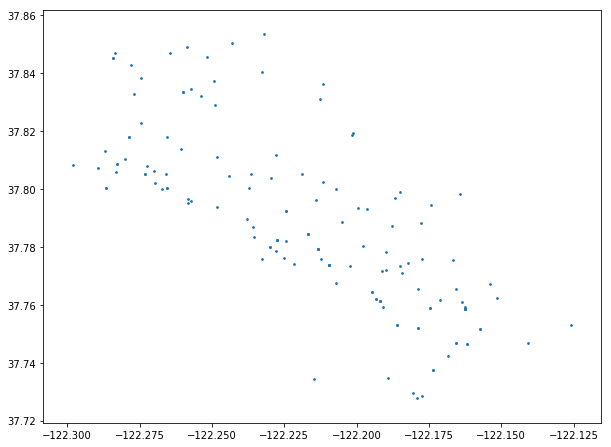

In [6]:
geoschools.plot(markersize=3);

In [7]:
#loading parks and splitting lat and long into separate columns
parks = pd.read_csv('Map_of_Parks_and_Recreation_Facilities.csv')
parks['Latitude'] = parks['Location 1'].str.split('\n').str[2].str.split(',').str[0].str[1:].astype('float')
parks['Longitude'] = parks['Location 1'].str.split('\n').str[2].str.split(',').str[1].str[0:-1].astype('float')
parks.head()

,Parks and Recreation Facilities,Facility Type,Phone Number,URL,Location 1,Latitude,Longitude
0,Lake Merritt Sail Boat House,Rental Facility,(510) 238-3187,http://www2.oaklandnet.com/Government/o/opr/s/...,"568 Bellevue Avenue\nOakland, CA\n(37.80676133...",37.806761,-122.256625
1,Brookdale,Tennis Court,(510) 444-5665,http://www2.oaklandnet.com/Government/o/opr/s/...,"Brookdale Ave &amp; High St\nOakland, CA\n(37....",37.805060,-122.273020
2,Allendale Park,Park,(510) 238-PARK,http://www2.oaklandnet.com/Government/o/opr/s/...,"3711 Suter Street\nOakland, CA\n(37.7899188971...",37.789919,-122.202924
3,Park Blvd Plaza Park,Park,(510) 238-PARK,http://www2.oaklandnet.com/Government/o/opr/s/...,"2100 Park Blvd\nOakland, CA\n(37.8006310964848...",37.800631,-122.247661
4,Rainbow,Recreation Center,(510) 615-5751,http://www2.oaklandnet.com/Government/o/opr/s/...,"5800 International Blvd\nOakland, CA\n(37.7654...",37.765493,-122.200297


In [8]:
#geocoding parks as point data
crs = {'init' :'epsg:4326'}
geometry = [Point(xy) for xy in zip(parks.Longitude, parks.Latitude)]
geoparks = GeoDataFrame(parks, crs=crs, geometry=geometry)
geoparks.head()

,Parks and Recreation Facilities,Facility Type,Phone Number,URL,Location 1,Latitude,Longitude,geometry
0,Lake Merritt Sail Boat House,Rental Facility,(510) 238-3187,http://www2.oaklandnet.com/Government/o/opr/s/...,"568 Bellevue Avenue\nOakland, CA\n(37.80676133...",37.806761,-122.256625,POINT (-122.2566247980454 37.80676133380701)
1,Brookdale,Tennis Court,(510) 444-5665,http://www2.oaklandnet.com/Government/o/opr/s/...,"Brookdale Ave &amp; High St\nOakland, CA\n(37....",37.805060,-122.273020,POINT (-122.2730199996731 37.80505999961946)
2,Allendale Park,Park,(510) 238-PARK,http://www2.oaklandnet.com/Government/o/opr/s/...,"3711 Suter Street\nOakland, CA\n(37.7899188971...",37.789919,-122.202924,POINT (-122.2029235119239 37.78991889713853)
3,Park Blvd Plaza Park,Park,(510) 238-PARK,http://www2.oaklandnet.com/Government/o/opr/s/...,"2100 Park Blvd\nOakland, CA\n(37.8006310964848...",37.800631,-122.247661,POINT (-122.2476606965575 37.80063109648487)
4,Rainbow,Recreation Center,(510) 615-5751,http://www2.oaklandnet.com/Government/o/opr/s/...,"5800 International Blvd\nOakland, CA\n(37.7654...",37.765493,-122.200297,POINT (-122.2002974915983 37.76549331082276)


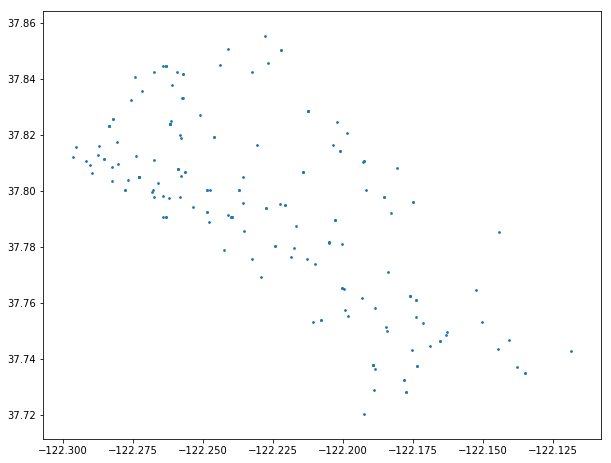

In [9]:
geoparks.plot(markersize=3);

In [10]:
bart = gpd.read_file('BART_Sta_13/BART_Sta_13.shp')
bart.head()

,STATION,OPERATOR,DIST,CO,geometry
0,NORTH BERKELEY,BART,4,ALA,POINT (-122.283347881478 37.87406119520771)
1,DOWNTOWN BERKELEY,BART,4,ALA,POINT (-122.268249538332 37.86968943870814)
2,ASHBY,BART,4,ALA,POINT (-122.2701189608313 37.85320737930983)
3,ROCKRIDGE,BART,4,ALA,POINT (-122.2517773834424 37.84450968784791)
4,MACARTHUR,BART,4,ALA,POINT (-122.2671204422818 37.82870504871252)


## Load Other Boundary Data

In [11]:
tracts = gpd.read_file('Alameda County US Census Tracts 2010/geo_export_90da157e-1183-4f96-ae48-e70be0e65a06.shp')
#tax_tracts = pd.merge(tracts, tax_clean, left_on="apn_sort", right_on="Sort Parcel", how="inner")
tracts.head()

,funcstat10,geoid10,tractce10,countyfp10,namelsad10,awater10,statefp10,intptlat10,intptlon10,aland10,mtfcc10,name10,geometry
0,S,06001437800,437800,001,Census Tract 4378,0.0,06,+37.6431464,-122.0686965,1276296.0,G5020,4378,POLYGON ((-122.0743010000002 37.64984300000005...
1,S,06001437400,437400,001,Census Tract 4374,0.0,06,+37.6428275,-122.0876478,860214.0,G5020,4374,POLYGON ((-122.0875480000002 37.64759400000005...
2,S,06001405800,405800,001,Census Tract 4058,0.0,06,+37.7939452,-122.2330985,519054.0,G5020,4058,POLYGON ((-122.2284180000002 37.79137600000006...
3,S,06001437500,437500,001,Census Tract 4375,0.0,06,+37.6440340,-122.0793899,633478.0,G5020,4375,POLYGON ((-122.0799780000002 37.64891100000006...
4,S,06001451501,451501,001,Census Tract 4515.01,0.0,06,+37.6733434,-121.7369701,5053907.0,G5020,4515.01,POLYGON ((-121.7189370000002 37.67472800000006...


In [12]:
citylimits = gpd.read_file('City of Oakland City Limits/geo_export_d9d8cc59-2c85-415c-bc13-d26992faaab8.shp')

## Clean and Merge Parcel and Tax Data

In [13]:
#Loading Polygon Shapefile
parcels = gpd.read_file('Alameda County Parcel Boundaries/geo_export_a85caf8b-4f4f-46a5-be18-af34498f0784.shp')
parcels_clean = parcels.drop(['page','book','editor','clca_categ','fid_parcel'], axis=1)
#print(type(parcels))
#print(parcels.head())

In [14]:
#load and drop fields from tax roll file
tax = pd.read_csv('Assessor_s_Office_Secured_Tax_Roll_-_2017_2018.csv')
tax_clean = tax.drop(['Situs Unit','TRA Primary','TRA Secondary','CLCA Land','CLCA Imps','Source','HOEX','OTEX','Print Parcel','Situs Zip + 4', 'Mailing Address Street','Mailing Address Unit','Mailing Address City State','Mailing Address Zip','Mailing Address Zip + 4','CKDIGIT','WSEQ','Mailing Address Effective Date','Econ Unit','Latest Document Input Date','Delete Date'], axis=1)
tax_clean.head()

,Sort Parcel,Situs Street Number,Situs Street Name,Situs City,Situs Zip,Land,Imps,Fixtures,BPP,HPP,Total Net Value,Latest Document Prefix,Latest Document Series,Latest Document Date,Use Code
0,051 481603000,142,SANDRINGHAM RD,PIEDMONT,94611,"520,200","1,213,800",0,0,0,"1,727,000","2,016","157,856",06/23/2016 12:00:00 AM,"1,100"
1,051 481603100,136,SANDRINGHAM RD,PIEDMONT,94611,"239,439","558,691",0,0,0,"791,130","1,999","39,179",01/29/1999 12:00:00 AM,"1,100"
2,051 481603200,130,SANDRINGHAM RD,PIEDMONT,94611,"665,645","1,647,173",0,0,0,"2,305,818","2,012","213,397",07/03/2012 12:00:00 AM,"1,100"
3,051 481603300,120,SANDRINGHAM RD,PIEDMONT,94611,"481,817","249,205",0,0,0,"724,022","2,013","136,132",04/17/2013 12:00:00 AM,"1,100"
4,051 481700101,20,SELBORNE DR,PIEDMONT,94611,"642,600","1,193,400",0,0,0,"1,836,000","2,016","138,794",06/02/2016 12:00:00 AM,"1,100"


In [15]:
#pd.merge(parcels, tax, on="Name", how="inner")
#tax_parcels = parcels_clean.set_index("apn_sort").join(tax_clean.set_index("Sort Parcel"), how="inner").reset_index()
tax_parcels = pd.merge(parcels_clean, tax_clean, left_on="apn_sort", right_on="Sort Parcel", how="inner")


#tax_parcels.head()
oakland_parcels = tax_parcels[tax_parcels['Situs City']=='OAKLAND']


In [16]:
zoning = gpd.read_file('City-wide Zoning Map/geo_export_e3412bab-6a4e-42e8-893b-592036e2869f.shp')
zoning.head()

,overlay,ordinance,znlabel,expiredate,perimeter,area,test,lastupdate,effctvdate,basezone,geometry
0,/S-19,12875,CIX-1/S-19,,1015.466097,5.512397e+06,CIX-1/S-19,20090304,20080718,CIX-1,POLYGON ((-122.2857308439033 37.82232725511785...
1,/S-19,12875,CIX-1/S-19,,1015.466097,5.744007e+05,CIX-1/S-19,20090304,20080718,CIX-1,POLYGON ((-122.2812909540165 37.80236514210691...
2,/S-19,12875,CIX-1/S-19,,17791.906465,3.983032e+06,CIX-1/S-19,20090304,20080718,CIX-1,(POLYGON ((-122.2993166973065 37.8062938028413...
3,,,OS (NP),,1498.555904,1.389631e+05,OS (NP),20090304,,OS (NP),POLYGON ((-122.1773177128875 37.72609018686309...
4,,,R-40,,2286.429366,1.662382e+05,R-40,20090304,,R-40,POLYGON ((-122.1824047150539 37.72864462309264...


#### Vacant Use Codes
800: Vacant residential tract lot  
1000: Vacant residential land, zoned 4 units or less  
1040: Vacant residential land, R&T 402.1  
3000: Vacant commercial land (may include misc. imps)  
4000: Vacant industrial land (may include misc. imps)  
5000: Vacant rural-res homesites, may incl misc. imps  
5700: Vacant rural land, not usable even for agriculture  
5900: Vacant rural land, non-renewal Williamson Act  
6000: Vacant land necessary part of institutional prop.  
6001: Government owned property - vacant land  
7000: Vacant apartment land, capable of 5 or more units  
7040: Vacant apartment land, R&T 402.1  
7090: Vacant apartment common area or use  

In [17]:
#filtering oakland_parcels to use codes with "vacant" in description
vacant_parcels = oakland_parcels[oakland_parcels['Use Code'].isin(['800', '1,000', '1,040', '3,000', '4,000', '5,000','5,700', '5,900', '6,000', '6,001', '7,000', '7,040', '7,090'])]
vacant_parcels.head()

,shape_st_4,apn_sort,shape_st_1,sub_parcel,date_updat,shape_stle,centroid_x,shape_star,comments,shape_st_3,...,Land,Imps,Fixtures,BPP,HPP,Total Net Value,Latest Document Prefix,Latest Document Series,Latest Document Date,Use Code
12,358.698505,048 622603302,6327.188477,2,2004-08-09,358.698505,6.091147e+06,6327.188477,,6327.188477,...,"14,032",0,0,0,0,"14,032","1,997","145,142",06/12/1997 12:00:00 AM,"1,000"
67,338.218168,048 622603400,5968.558594,,2004-08-09,338.218168,6.091158e+06,5968.558594,,5968.558594,...,"14,032",0,0,0,0,"14,032","1,997","145,142",06/12/1997 12:00:00 AM,"1,000"
102,351.331591,048 622603101,5163.844727,1,2004-08-09,351.331591,6.091134e+06,5163.844727,,5163.844727,...,"14,032",0,0,0,0,"14,032","1,997","145,142",06/12/1997 12:00:00 AM,"1,000"
113,566.831427,048 633000704,20075.475586,4,2004-08-09,566.831427,6.092717e+06,20075.475586,,20075.475586,...,"81,443",0,0,0,0,"81,443","2,006","135,203",04/06/2006 12:00:00 AM,"1,000"
131,384.256286,048 622900200,7296.671875,,2004-08-09,384.256286,6.090753e+06,7296.671875,,7296.671875,...,"22,274",0,0,0,0,"22,274","2,001","382,779",10/08/2001 12:00:00 AM,"1,000"


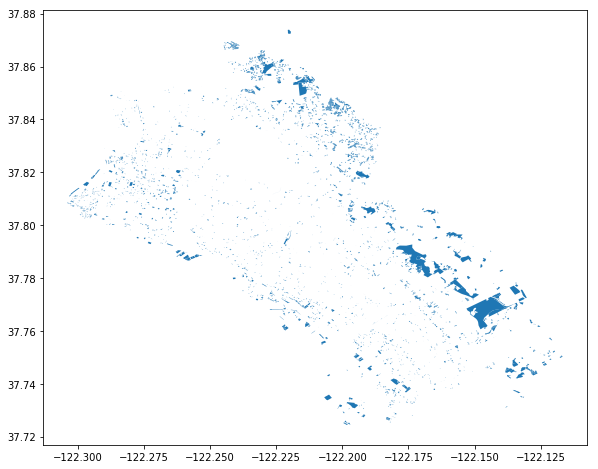

In [31]:
vacant_parcels.plot();


In [57]:
#checking parcel counts

#oakland_parcels.shape: 401,947 parcels
#vacant_parcels.shape: 4,142 parcels
#zoning.shape: 1,045 zones

oakland_parcels_clean = oakland_parcels[oakland_parcels['geometry'].notnull()]
#oakland_parcels_clean.shape: 98,460 parcels, lost 300k+ parcels

vacant_parcels_clean = vacant_parcels[vacant_parcels['geometry'].notnull()]
#vacant_parcels_clean.shape: 4,142 parcels, lost 0 parcels

zoning_clean = zoning[zoning['geometry'].notnull()]
#zoning_clean.shape: 993 zones, lost 52 zones


#vacant_parcels_zone.shape: 4,992
#oakland_parcels_zone.shape: 112,329

In [58]:
vacant_parcels_clean['Use Code']= vacant_parcels_clean['Use Code'].str.replace(',', '')
vacant_parcels_clean['Use Code'] = vacant_parcels_clean['Use Code'].astype('int')

In [59]:
vacant_parcels_clean['Land']= vacant_parcels_clean['Land'].str.replace(',', '')
vacant_parcels_clean['Land'] = vacant_parcels_clean['Land'].astype('int')

In [60]:
vacant_parcels_clean['Imps']= vacant_parcels_clean['Imps'].str.replace(',', '')
vacant_parcels_clean['Imps'] = vacant_parcels_clean['Imps'].astype('int')

In [61]:
vacant_parcels_clean['Total Net Value']= vacant_parcels_clean['Total Net Value'].str.replace(',', '')
vacant_parcels_clean['Total Net Value'] = vacant_parcels_clean['Total Net Value'].astype('int')

In [62]:
vacant_parcels_clean.head()

,shape_st_4,apn_sort,shape_st_1,sub_parcel,date_updat,shape_stle,centroid_x,shape_star,comments,shape_st_3,...,Land,Imps,Fixtures,BPP,HPP,Total Net Value,Latest Document Prefix,Latest Document Series,Latest Document Date,Use Code
12,358.698505,048 622603302,6327.188477,2,2004-08-09,358.698505,6.091147e+06,6327.188477,,6327.188477,...,14032,0,0,0,0,14032,"1,997","145,142",06/12/1997 12:00:00 AM,1000
67,338.218168,048 622603400,5968.558594,,2004-08-09,338.218168,6.091158e+06,5968.558594,,5968.558594,...,14032,0,0,0,0,14032,"1,997","145,142",06/12/1997 12:00:00 AM,1000
102,351.331591,048 622603101,5163.844727,1,2004-08-09,351.331591,6.091134e+06,5163.844727,,5163.844727,...,14032,0,0,0,0,14032,"1,997","145,142",06/12/1997 12:00:00 AM,1000
113,566.831427,048 633000704,20075.475586,4,2004-08-09,566.831427,6.092717e+06,20075.475586,,20075.475586,...,81443,0,0,0,0,81443,"2,006","135,203",04/06/2006 12:00:00 AM,1000
131,384.256286,048 622900200,7296.671875,,2004-08-09,384.256286,6.090753e+06,7296.671875,,7296.671875,...,22274,0,0,0,0,22274,"2,001","382,779",10/08/2001 12:00:00 AM,1000


# ERROR

In [22]:
oakland_parcels_zone = gpd.sjoin(oakland_parcels_clean, zoning_clean, how="inner", op='intersects')
oakland_parcels_zone[:10]

,shape_st_4,apn_sort,shape_st_1,sub_parcel,date_updat,shape_stle,centroid_x,shape_star,comments,shape_st_3,...,overlay,ordinance,znlabel,expiredate,perimeter,area,test,lastupdate,effctvdate,basezone
0,682.987896,048 629806800,27216.841797,,2004-08-09,682.987896,6.093121e+06,27216.841797,,27216.841797,...,,,R-30,,3640.837578,3.390497e+08,R-30,20090304,,R-30
1,340.219894,048 629800302,6525.494141,2,2004-08-09,340.219894,6.092186e+06,6525.494141,,6525.494141,...,,,R-30,,3640.837578,3.390497e+08,R-30,20090304,,R-30
2,335.407173,048 629907100,7114.140625,,2004-08-09,335.407173,6.092335e+06,7114.140625,,7114.140625,...,,,R-30,,3640.837578,3.390497e+08,R-30,20090304,,R-30
3,485.351439,048 631302300,11657.067383,,2004-08-09,485.351439,6.091841e+06,11657.067383,,11657.067383,...,,,R-30,,3640.837578,3.390497e+08,R-30,20090304,,R-30
6,370.930873,048 643100700,8919.704102,,2004-08-09,370.930873,6.089969e+06,8919.704102,,8919.704102,...,,,R-30,,3640.837578,3.390497e+08,R-30,20090304,,R-30
7,494.248261,048 631302500,11958.000977,,2004-08-09,494.248261,6.091982e+06,11958.000977,,11958.000977,...,,,R-30,,3640.837578,3.390497e+08,R-30,20090304,,R-30
8,320.002535,048 631308700,6000.066406,,2004-08-09,320.002535,6.091454e+06,6000.066406,,6000.066406,...,,,R-30,,3640.837578,3.390497e+08,R-30,20090304,,R-30
9,348.159619,048 629806000,7105.470703,,2004-08-09,348.159619,6.092737e+06,7105.470703,,7105.470703,...,,,R-30,,3640.837578,3.390497e+08,R-30,20090304,,R-30
10,561.680114,048 633000802,17248.619141,2,2004-08-09,561.680114,6.092552e+06,17248.619141,,17248.619141,...,,,R-30,,3640.837578,3.390497e+08,R-30,20090304,,R-30
11,597.995532,048 633101101,22241.985352,1,2004-08-09,597.995532,6.092930e+06,22241.985352,,22241.985352,...,,,R-30,,3640.837578,3.390497e+08,R-30,20090304,,R-30


In [28]:
vacant_parcels_zone = gpd.sjoin(vacant_parcels_clean, zoning_clean, how="inner", op='intersects')
vacant_parcels_zone.head()

,shape_st_4,apn_sort,shape_st_1,sub_parcel,date_updat,shape_stle,centroid_x,shape_star,comments,shape_st_3,...,overlay,ordinance,znlabel,expiredate,perimeter,area,test,lastupdate,effctvdate,basezone
12,358.698505,048 622603302,6327.188477,2,2004-08-09,358.698505,6.091147e+06,6327.188477,,6327.188477,...,,,R-30,,3640.837578,3.390497e+08,R-30,20090304,,R-30
67,338.218168,048 622603400,5968.558594,,2004-08-09,338.218168,6.091158e+06,5968.558594,,5968.558594,...,,,R-30,,3640.837578,3.390497e+08,R-30,20090304,,R-30
102,351.331591,048 622603101,5163.844727,1,2004-08-09,351.331591,6.091134e+06,5163.844727,,5163.844727,...,,,R-30,,3640.837578,3.390497e+08,R-30,20090304,,R-30
113,566.831427,048 633000704,20075.475586,4,2004-08-09,566.831427,6.092717e+06,20075.475586,,20075.475586,...,,,R-30,,3640.837578,3.390497e+08,R-30,20090304,,R-30
131,384.256286,048 622900200,7296.671875,,2004-08-09,384.256286,6.090753e+06,7296.671875,,7296.671875,...,,,R-30,,3640.837578,3.390497e+08,R-30,20090304,,R-30


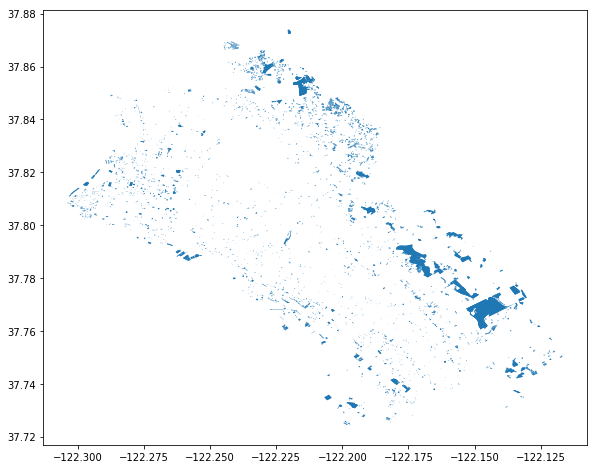

In [30]:
vacant_parcels_zone.plot()

## Projections

In [ ]:
#projecting to MTC standard (Universal Transverse Mercator (UTM), Zone 10N, NAD83)
mtc_crs = '+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs '
bart_proj = bart.to_crs(mtc_crs)
oakland_parcels_proj = oakland_parcels.to_crs(mtc_crs)
vacant_parcels_proj = vacant_parcels.to_crs(mtc_crs)
citylimits_proj = citylimits.to_crs(mtc_crs)
zoning_proj = zoning_clean.to_crs(mtc_crs)
vacant_parcels_clean_proj = vacant_parcels_clean.to_crs(mtc_crs)

## Calculations

In [81]:
#groupby use codes for summary stats
zip_values = vacant_parcels_clean_proj['Total Net Value'].groupby(vacant_parcels_clean_proj['Situs Zip']).sum()
zip_values

Situs Zip
93602        34173
94504        62133
94546       265064
94577       781470
94601     39253121
94602      7272768
94603    117826506
94605    111440849
94606     48797229
94607    137880719
94608     65863274
94609     54033617
94610      7079570
94611    104415786
94612    198466908
94613            0
94614        37289
94618     67393909
94619     21237183
94621     70518887
94702        84104
94704      1584919
94705     16289984
Name: Total Net Value, dtype: int64

In [74]:
#add parcel area
vacant_parcels_clean_proj['Parcel Area'] = vacant_parcels_clean_proj.area/3.861e-7

In [79]:
#summary calculations
total_value = vacant_parcels_clean_proj['Total Net Value'].sum()
median_value = vacant_parcels_clean_proj['Total Net Value'].median()

total_land = vacant_parcels_clean_proj['Land'].sum()
median_land = vacant_parcels_clean_proj['Land'].median()

total_imps = vacant_parcels_clean_proj['Imps'].sum()
median_imps = vacant_parcels_clean_proj['Imps'].median()

total_area = vacant_parcels_clean_proj['Parcel Area'].sum()
#15,613,832,452,577.998
median_area = vacant_parcels_clean_proj['Parcel Area'].median()
#1,430,580,226.2474828

15613832452577.998

In [ ]:
#get tracts for oakland
oakland_tracts = gpd.overlay(tracts,citylimits, how="intersection")


In [ ]:
oakland_tracts_clean = oakland_tracts.drop_duplicates(subset=['tractce10'], keep=False)


In [ ]:
oakland_census = pd.merge(oakland_tracts, census, left_on="tractce10", right_on="tract", how="inner")

In [ ]:
oakland_census.plot()

In [ ]:
#show column field names
oakland_parcels_proj.columns.values

## Create at least two different maps, with no bounding box, and a title, and at least two layers, showing data attributes as choroplethic maps (polygons or points) with an appropriate colormap.

In [ ]:
bart_parcels = gpd.sjoin(bart_proj, oakland_parcels_proj, how="inner", op='intersects')
bart_parcels.head()

In [ ]:
#normalize parcel value per sqft
oakland_parcels_proj['Parcel Value Per SQFT'] = oakland_parcels_proj['Total Net Value']/oakland_parcels_proj['Parcel Area']
#oakland_parcels.plot(color='none', column='Parcel Value Per SQFT', cmap = 'OrRd', edgecolor='grey', linewidth=.2);


In [ ]:
bart_proj.plot()

## Questions 